# Creating comet models

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Generate the models

In [2]:
files = glob('../data/eleanor/**/*.fits', recursive=True)
random.shuffle(files)

### Create models

In [3]:
folder = '../plain' # do not add the dash after folder name here as it is done in the loop for saving files

In [4]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 2:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

In [5]:
os.makedirs(folder, exist_ok=True)
fails = []
times = []
rmsfails = []
ticid = []

min_snr = 5
max_snr = 20

for i in tqdm(files[0:10000]):

    ### READ IN LIGHTCURVE
    lc, lc_info = import_lightcurve(i, drop_bad_points=True)
    sector = f"{lc_info['sector']:02d}"
    tic = lc_info['TIC_ID']
    lc = lc['TIME','PCA_FLUX','QUALITY','FLUX_ERR']
    time, flux, quality, real, flux_error = clean_data(lc)
    t0 = np.random.uniform(lc['TIME'][0],lc['TIME'][-1])
    times.append(t0)
    ticid.append(tic)
    np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}.npy", np.array([time,flux/np.nanmedian(flux), flux_error]))
    

100%|█| 10000/10000 [04:47<00:00, 34.81it/s]


---

### Converting non-model lightcurves to `.npy` arrays

Issue: no. of injected lightcurves must be more than test sample

In [6]:
# for i in tqdm(files[10000:20000]):
#     try:
#         lc, info = import_lightcurve(i)
#         tic = info['TICID']
    
#         fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))

#         time = np.array(lc['TIME'])
#         flux = np.array(lc['SAP_FLUX'] / np.nanmedian(lc['SAP_FLUX']))
#         np.save(f"../models/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
#     except TypeError:
#         continue

## Loading comet models

In [7]:
comets =  glob('../plain/*.npy')
comets[0:3]

['../plain/266661172_sector07.npy',
 '../plain/143442888_sector07.npy',
 '../plain/452849560_sector07.npy']

### Sample plot of Full Lightcurves

In [8]:
# num_files_per_grid = 100

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 10, 10
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path,allow_pickle=True)
#         time = file[0]
#         flux = file[1]/np.nanmedian(file[1])


        
#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]
        

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
    

In [9]:
# num_files_per_grid = 25  # Since you want a 5x5 grid

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 5, 5  # Set the number of rows and columns for the grid
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path, allow_pickle=True)
#         time = file[0]
#         flux = file[1] / np.nanmedian(file[1])

#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
#     break

## Build catalog

In [10]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
data.TIC = data.TIC.astype(int)
t = Table.from_pandas(data)

t.write('plain-eleanor-lite.txt', format='ascii', overwrite=True) 

In [12]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/plain/',
                         catalog='/Users/azib/Documents/open_source/nets2/notebooks/plain-eleanor-lite.txt',cadences=168,training=0.8,validation=0.9,frac_balance=0.3)

Reading in training set files.


100%|█| 10000/10000 [00:03<00:00, 2635.09it/


8639 positive classes (flare)
33403 negative classes (no flare)
26.0% class imbalance



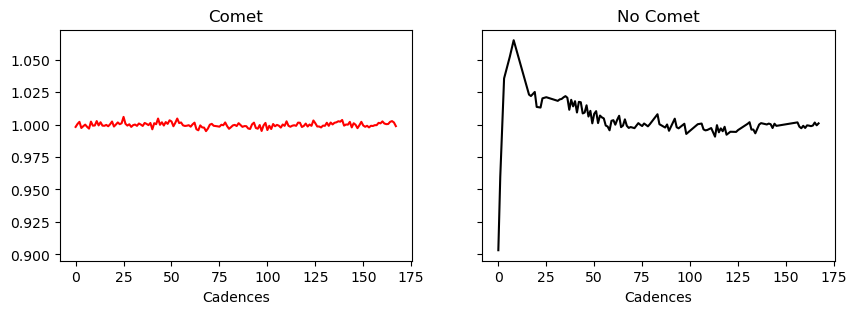

In [14]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[1]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[1]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

### Example of Plain Dataset

In [15]:
dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_nc]
# def is_minimum_in_middle(array, margin=2):
#     middle_index = array.shape[0] // 2
#     min_index = np.argmin(array)
#     return abs(min_index - middle_index) <= margin

# # Example numpy array
# arr = np.random.rand(80, 200, 1)

# # Remove arrays where the minimum point is not within 5 points of the middle
# filtered_arr = [array for array in arr if is_minimum_in_middle(array)]

# # Convert filtered_arr back to numpy array
# filtered_arr = np.array(filtered_arr)

# # Remove arrays where the minimum point is not within 5 points of the middle
# filtered_arr = [array for array in dsmodels if is_minimum_in_middle(array)]

# # Convert filtered_arr back to numpy array
# filtered_arr = np.array(filtered_arr)
# dsmodels = filtered_arr

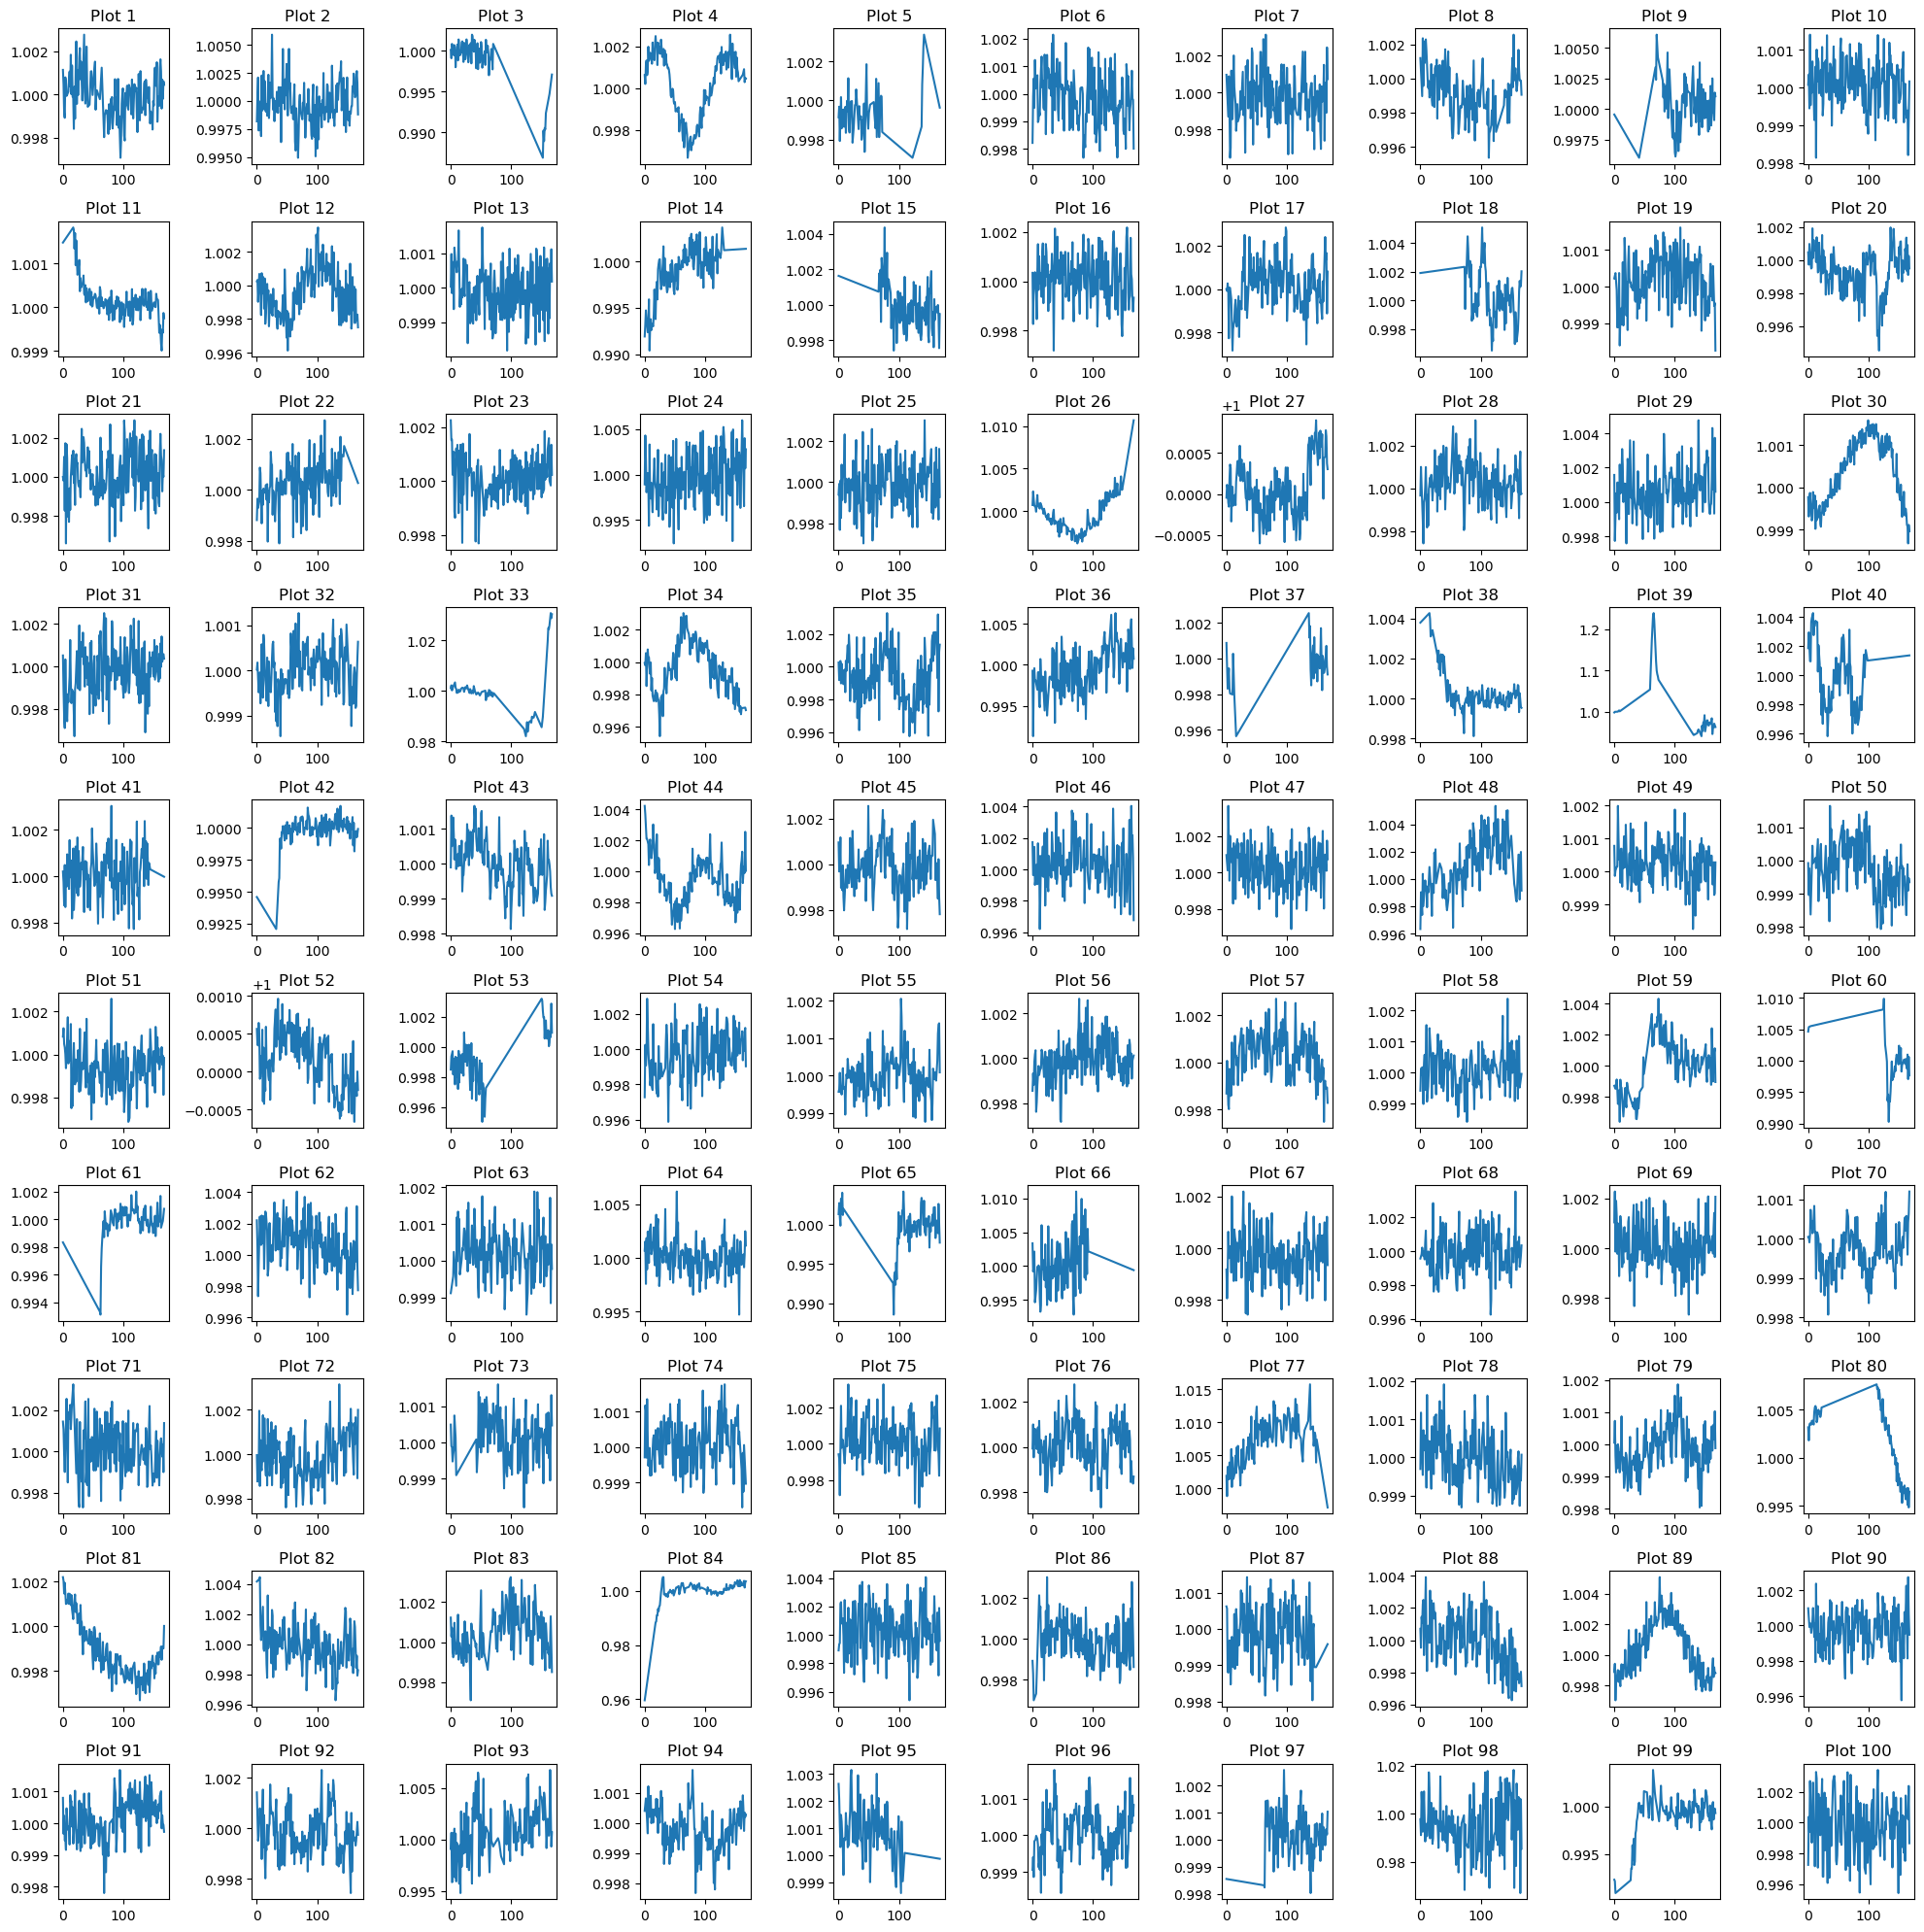

In [16]:
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break

**Note**: Index is one behind plot number

In [18]:
int(ds.training_ids[ind_pc][17])

268909207

In [69]:
len(ds.train_data[ind_pc])

4012